# Exploration of `ExPeCoN`

Running analyses for `ExPeCoN`

results are published in Forster et al., 2024 (hopefully)
___

    Author:  Carina Forster et al.
    Contact: forster@cbs.mpg.de
    Years:   2023

___

## Setup 

In [34]:
# turn off warnings for a cleaner output
import warnings

warnings.filterwarnings('ignore')

In [35]:
# import packages
import pandas as pd
from pathlib import Path

# expecon_ms functions
from expecon_ms.configs import config, path_to

# import functions for behavioral analysis
from expecon_ms.behav import figure1 as behav

# Import functions from expecon_package for preproccesing eeg data
from expecon_ms.eeg.preprocessing import prepro as pp
from expecon_ms.eeg.preprocessing import ica

# import functions for EEG analysis and visualization
from expecon_ms.eeg.sensor import evokeds as evo
from expecon_ms.eeg.sensor import tfr_contrasts as tfr
from expecon_ms.eeg.sensor import tfr_trial

# import functions for source analysis
from expecon_ms.eeg.source import source_reco

Last Commit Date for E:\expecon_ms\code\expecon_ms\eeg\sensor\tfr_trial.py : Wed Dec 20 11:51:40 2023 +1000
Last Commit Date for E:\expecon_ms\code\expecon_ms\eeg\source\source_reco.py : Fri Jan 5 05:05:45 2024 +0100


In [36]:
# Define the output for mne functions
import mne

mne.set_log_level('CRITICAL')

In [2]:
# Set global vars & paths (unused at the moment)

# this doesn't work for some reason
# the variables set here are not recognized in the functions

# raw concatenated eeg data
save_dir_concatenated_raw1 = Path(path_to.data.eeg.RAW_expecon1)
save_dir_concatenated_raw2 = Path(path_to.data.eeg.RAW_expecon2)
save_dir_concatenated_raw1.mkdir(parents=True, exist_ok=True)
save_dir_concatenated_raw2.mkdir(parents=True, exist_ok=True)

# stimulus locked
save_dir_stim_1 = Path(path_to.data.eeg.preprocessed.stimulus_expecon1)
save_dir_stim_2 = Path(path_to.data.eeg.preprocessed.stimulus_expecon2)
save_dir_stim_1.mkdir(parents=True, exist_ok=True)
save_dir_stim_2.mkdir(parents=True, exist_ok=True)

# cue locked
save_dir_cue_1 = Path(path_to.data.eeg.preprocessed.cue_expecon1)
save_dir_cue_2 = Path(path_to.data.eeg.preprocessed.cue_expecon2)
save_dir_cue_1.mkdir(parents=True, exist_ok=True)
save_dir_cue_2.mkdir(parents=True, exist_ok=True)

# directory that contains the cleaned epochs
dir_clean_epochs_expecon1 = Path(path_to.data.eeg.preprocessed.ica.clean_epochs_expecon1)
dir_clean_epochs_expecon2 = Path(path_to.data.eeg.preprocessed.ica.clean_epochs_expecon2)

# EEG cap layout file
filename_montage = Path(path_to.data.templates)
filename_montage.mkdir(parents=True, exist_ok=True)

# raw behavioral data
behav_path = Path(path_to.data.behavior)
behav_path.mkdir(parents=True, exist_ok=True)

# participant IDs
id_list_expecon1 = config.participants.ID_list_expecon1
id_list_expecon2 = config.participants.ID_list_expecon2

# pilot data counter (for expecon 1, participant ID starts with ID007)
pilot_counter = config.participants.pilot_counter

# data_cleaning parameters defined in config.toml
rt_max = config.behavioral_cleaning.rt_max
rt_min = config.behavioral_cleaning.rt_min
hitrate_max = config.behavioral_cleaning.hitrate_max
hitrate_min = config.behavioral_cleaning.hitrate_min
farate_max = config.behavioral_cleaning.farate_max
hit_fa_diff = config.behavioral_cleaning.hit_fa_diff

## Analyse 

1. Behavioral data analysis (Signal detection theory based)

In [8]:
# check the function arguments the docs
help(behav.plot_figure1_grid)

Help on function plot_figure1_grid in module expecon_ms.behav.figure1:

plot_figure1_grid(expecon: int, exclude_high_fa: bool)
    Plot the figure 1 grid and the behavioral data for the EXPECON study.
    
    Args:
    ----
    expecon: int : which study to analyze
    exclude_high_fa: bool: whether to exclude participants with high false alarm rates
    
    Return:
    ------
    None



Mean hit rate: 0.58
Standard deviation: 0.10
Minimum hit rate: 0.42
Maximum hit rate: 0.81
Blocks with hit rates > 0.9 or < 0.2:  11
Blocks with false alarm rates > 0.4:  1
Blocks with hit rates < false alarm rates:  2
Index of participants with high fa-rates: (array([ 8, 36, 39], dtype=int64),)


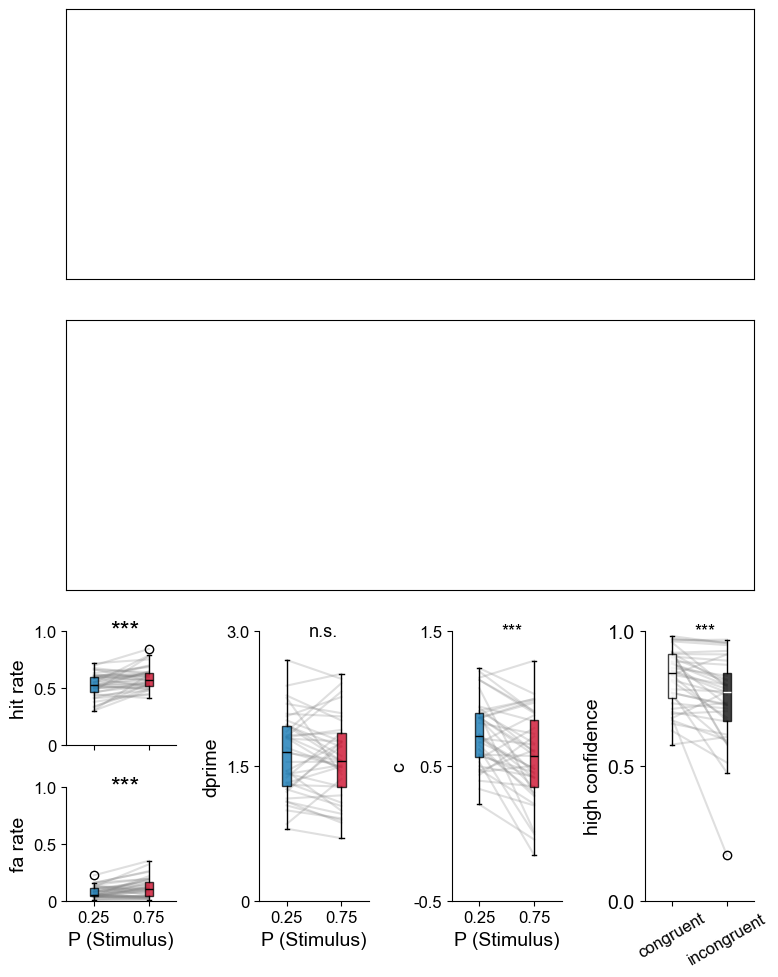

'saved figure 1'

In [5]:
behav.plot_figure1_grid(expecon=1, exclude_high_fa=True)

2. Preprocessing EEG data

In [ ]:
# function expects a raw object with .fif file ending
pp.prepro(study=2, trigger='stimulus', l_freq=1, h_freq=40, tmin=-1,
        tmax=1, resample_rate=250,
        sf=2500, detrend=1, ransac=1, autoreject=0)

# how many channels were interpolated?
pp.n_channels_interpolated(study=2, trigger='stimulus', l_freq=0.1)

# run ica on clean, epoched data
ica.run_ica(study=2, infomax=1, save_psd=1)
# correlate with EOG and ECG and mark bad componets for rejection

ica.label_ica_correlation(study=2)

# usa icalabel to mark components for rejection
#ica.label_iclabel(study=1)

ICA stats

In [13]:
# which study to run the analysis on
study = 2

In [14]:
# load the csv file that contains the number of components rejected
df = pd.read_csv(f"E:\expecon_ms\data\eeg\prepro_ica\clean_epochs_corr{str(study)}\ica_components_stats_icacorr.csv")

# mean components rejected
print(f' on average {df["0"].mean()} components were rejected')
print(f' the sdt of components rejected is {df["0"].std()}')
print(f' the maximum of components rejected is {df["0"].max()}')
print(f' the minimum of components rejected is {df["0"].min()}')

 on average 3.5384615384615383 components were rejected
 the sdt of components rejected is 1.1663292359534148
 the maximum of components rejected is 6
 the minimum of components rejected is 1


2. Evoked potentials

In [ ]:
# compare evokeds and plot contrasts
evokeds = evo.create_contrast(study=2, drop_bads=True, laplace=False,
                              subtract_evoked=False, save_data_to_disk=False,
                              save_drop_log=False)

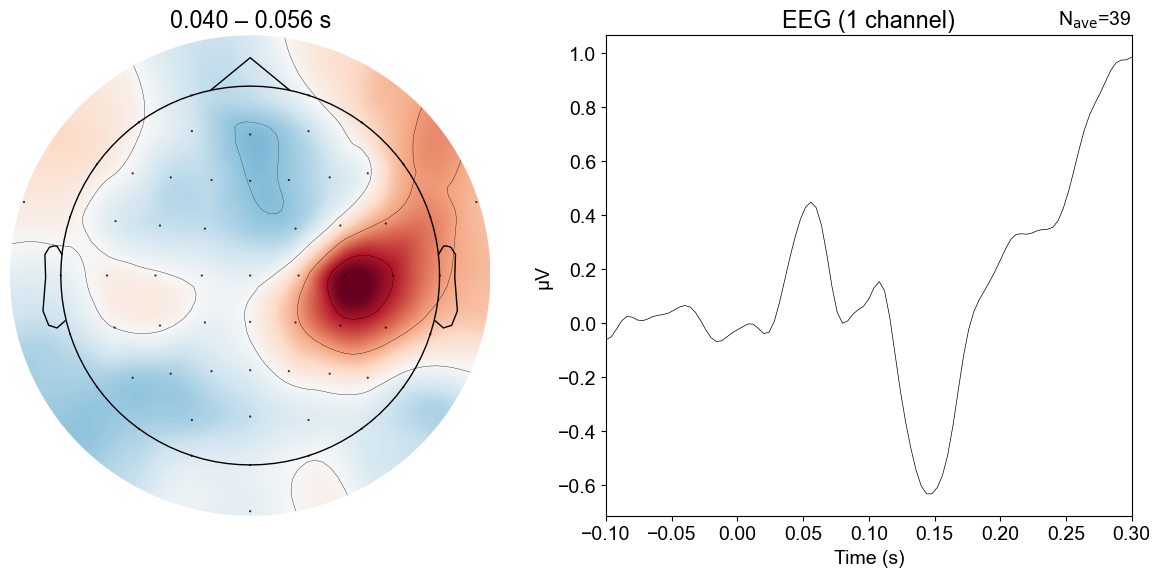

In [30]:
# plot evoked contrast and topography for the contrast
evo.plot_roi(study=2, data=evokeds, tmin=-0.1, tmax=0.3, tmin_base=-0.1, tmax_base=0)

3. Time-frequency analysis

In [ ]:
# compute tfr representations for each condition
tfr.compute_tfr(study=2, cond='prev_resp', tmin=-0.4, tmax=0, fmax=35,
 fmin=3, laplace=False, induced=False, mirror=True, drop_bads=True)

stimulus probability contrast

In [29]:
# load the tfr data for each condition for probability conds.

tfr_a_cond, tfr_b_cond = tfr.load_tfr_conds(studies=[1, 2], cond='probability',
                                            cond_a_name='high_mirror',
                                            cond_b_name='low_mirror',
                                            cond_a_names=['high_prevhit_mirror',
                                                          'high_prevmiss_mirror',
                                                          'high_prevcr_mirror'],
                                            cond_b_names=['low_prevhit_mirror',
                                                          'low_prevmiss_mirror',
                                                          'low_prevcr_mirror'])

Shape of array for cluster test should be participants x frequencies x timepoints: (43, 32, 101)
smallest cluster p-value: 0.1508
Shape of array for cluster test should be participants x frequencies x timepoints: (39, 32, 101)
smallest cluster p-value: 0.0001


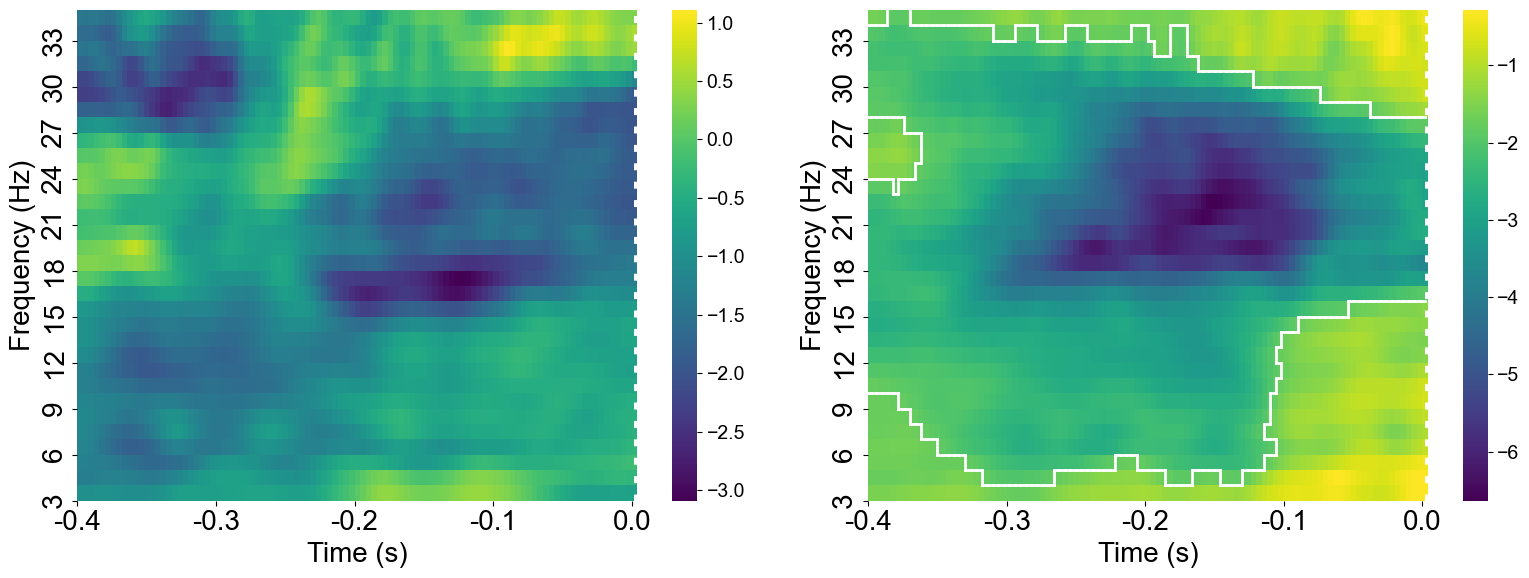

(array([[ -8.26394672,  -8.26394672,  -8.26394672, ...,  -1.70490447,
          -1.13701363,  -1.13701363],
        [ -8.79775027,  -8.79775027,  -8.79775027, ...,  -1.13701363,
          -1.13701363,  -1.13701363],
        [ -8.77129276,  -8.77129276,  -8.77129276, ...,  -2.27138483,
          -2.27138483,  -2.27138483],
        ...,
        [-11.15986107, -11.15986107, -11.60807976, ...,  -3.95778926,
          -3.95778926,  -3.39832523],
        [-10.23290011, -10.23290011, -10.7023679 , ...,  -3.96778926,
          -3.95778926,  -2.8360086 ],
        [ -8.77129276,  -8.77129276,  -8.77129276, ...,  -3.39832523,
          -2.8360086 ,  -2.27138483]]),
 array([0.11, 0.11, 0.11, ..., 0.84, 0.93, 0.98]))

In [28]:
# run cluster based permutation tests for the conditions contrasts
# and plot sign. cluster
tfr.plot_tfr_cluster_test_output(cond='probability', tfr_a_cond=tfr_a_cond, tfr_b_cond=tfr_b_cond,
threed_test=False, cond_a_name='high', cond_b_name='low', channel_names=['CP4'])

previous response contrast

In [31]:
# load the tfr data for each condition for prev_resp conds.
tfr_a_cond, tfr_b_cond = tfr.load_tfr_conds(studies=[1, 2], cond='prev_resp',
                                            cond_a_name='prevyesresp_highprob_stim_mirror',
                                            cond_b_name='prevnoresp_highprob_stim_mirror',
                                            cond_a_names=None, cond_b_names=None)

Shape of array for cluster test should be participants x frequencies x timepoints: (43, 32, 101)
smallest cluster p-value: 0.0174
Shape of array for cluster test should be participants x frequencies x timepoints: (39, 32, 101)
smallest cluster p-value: 0.6477


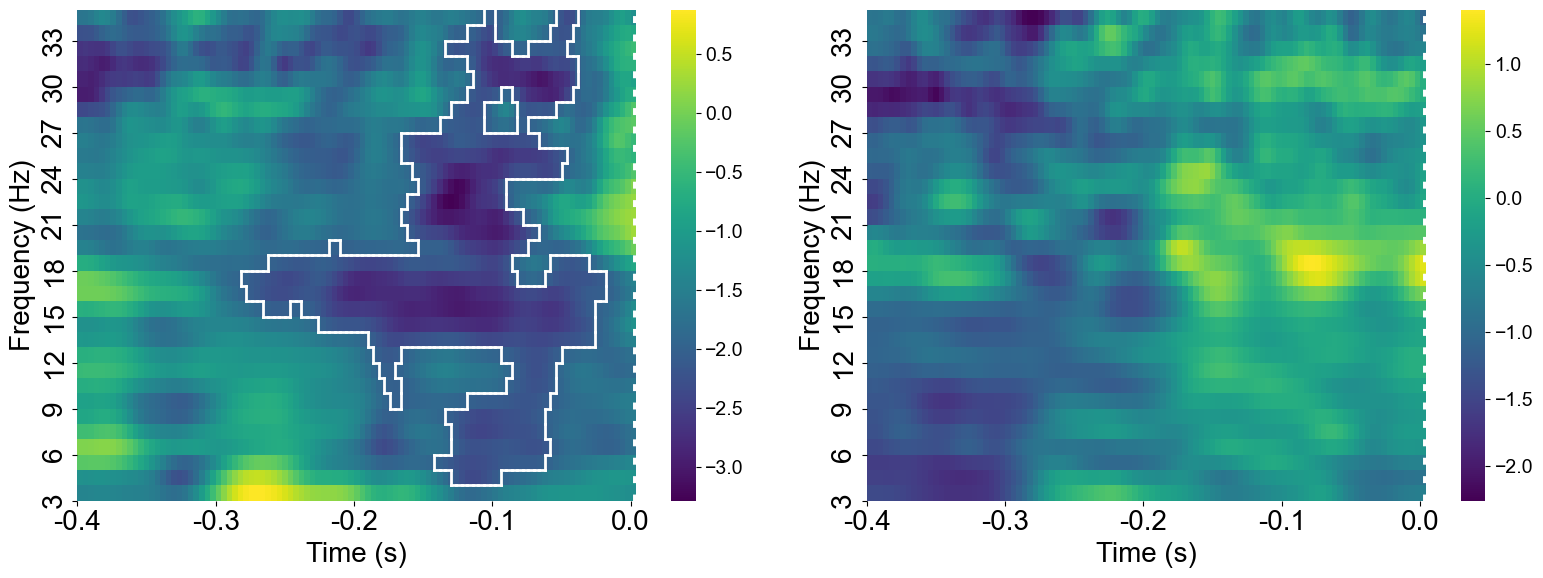

(array([[-4.16348357, -4.16348357, -4.16348357, ..., -1.3489882 ,
         -1.3489882 , -1.29154257],
        [-4.24472396, -4.24472396, -4.24472396, ..., -1.39370956,
         -1.39370956, -1.39370956],
        [-4.26472396, -4.26472396, -4.26472396, ..., -1.29154257,
         -1.29154257, -1.29154257],
        ...,
        [-3.1998889 , -3.38830333, -3.38830333, ..., -1.21638952,
         -1.21638952, -1.16739973],
        [-2.8680757 , -2.8680757 , -3.1998889 , ..., -1.21638952,
         -1.23638952, -1.25053166],
        [-3.1998889 , -3.1998889 , -3.1998889 , ..., -1.21638952,
         -1.23638952, -1.27053166]]),
 array([0.7, 0.7, 0.7, ..., 1. , 1. , 1. ]))

In [32]:
# run cluster based permutation tests for the conditions contrasts
# and plot sign. cluster
tfr.plot_tfr_cluster_test_output(cond='prev_resp', tfr_a_cond=tfr_a_cond, tfr_b_cond=tfr_b_cond,
                                 threed_test=False, cond_a_name='prevyesresp',
                                 cond_b_name='prevnoresp', channel_names=['CP4'])

In [ ]:
# add alpha and beta power per trial to behavioral data and save in csv file for further analysis in R
tfr_trial.save_band_power_per_trial(study=2,
                                    time_intervals={'pre': [(-0.2,0), (-0.3, -0.1)]},
                                    channel_names=['CP4'],
                                    mirror=True)

4. Source reconstruction

In [37]:
# run source reconstruction for each condition
source_reco.run_source_reco(study=2,
                            cond="probability",
                            mirror=True,
                            dics=True, fmin=15, fmax=25,
                            tmin=-0.4, tmax=0,
                            drop_bads=True,
                            plot_alignment=False)

Analyzing 001
Skipping 001 because it already exists.
Analyzing 002
Skipping 002 because it already exists.
Analyzing 003
Skipping 003 because it already exists.
Analyzing 004
Skipping 004 because it already exists.
Analyzing 005
Skipping 005 because it already exists.
Analyzing 006
Skipping 006 because it already exists.
Analyzing 007
Skipping 007 because it already exists.
Analyzing 008
Skipping 008 because it already exists.
Analyzing 009
Skipping 009 because it already exists.
Analyzing 010
Skipping 010 because it already exists.
Analyzing 011
Skipping 011 because it already exists.
Analyzing 012
Skipping 012 because it already exists.
Analyzing 013
Processing 013.
Analyzing 014
Skipping 014 because it already exists.
Analyzing 015
Skipping 015 because it already exists.
Analyzing 016
Skipping 016 because it already exists.
Analyzing 017
Skipping 017 because it already exists.
Analyzing 018
Skipping 018 because it already exists.
Analyzing 019
Skipping 019 because it already exists

In [38]:
# plot source contrast (grand average over all participants)
# opens plots in separate windows
source_reco.plot_grand_average_source_contrast(study=2, cond='prev_resp', method='beamformer')

% of significant vertices: 0.0012201073694485115


### Intermediate summary
Analysis of eeg data showed that in somatosensory regions, prestimulus beta power codes stimulus expectations in the volatile environment. For the stable environment prestimulus beta power codes the previous response. Source reconstruction shows the beta power source for stimulus probability in S2 and for previous responses in posterior cortex and ACC.